In [ ]:
from OptimalHedging.GBM import GBMSimulator
from OptimalHedging.Heston import HestonSimulator
from OptimalHedging.JumpDiff import JumpDiffusionSimulator

In [ ]:
from OptimalHedging.Simulator import BaseSimulator
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev
from typing import Dict, List, Tuple
import OptimalHedging.tools as tools


class GBMSimulator(BaseSimulator):
    """
    Simulator for Geometric Brownian Motion (GBM) + optimal hedging machinery.
    """

    def __init__(self, 
                 **base_kwargs):
        """
        Initialize the GBM simulator.

        This class does not introduce new parameters and simply forwards
        all arguments to the BaseSimulator initializer.
        """
        super().__init__(**base_kwargs)

    # ============================================================
    # 0. Underlying S and derivative H (your original code)
    # ============================================================

    def simulate_S(self) -> np.ndarray:
        """
        Simulate Geometric Brownian Motion (GBM) paths using a fully vectorized Euler–Maruyama scheme.

            dS = mu * S * dt + sigma * S * dW

        Returns
        -------
        S : ndarray, shape (M, steps)
            Simulated GBM underlying asset price paths.
        """
        dW = np.random.normal(loc=0.0,
                              scale=np.sqrt(self.dt),
                              size=(self.M, self.steps - 1))    # (M, steps-1)

        # multiplicative Euler step: S_{n+1} = S_n * (1 + mu*dt + sigma*dW)
        factors = 1 + self.mu * self.dt + self.sigma * dW
        factors = np.hstack((np.ones((self.M, 1)), factors))    # insert initial factor = 1
        S = self.S0 * np.cumprod(factors, axis=1)               # (M, steps)
        
        self.S_GBM = S
        self.dW_GBM = dW

        return S

    def simulate_H(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Estimate H(t,S) = E[(S_T - K)^+ | S_t = S] and derivatives using a single-pass 
        LSMC (least-squares Monte Carlo) regression on the already-simulated paths.

        Approach
        --------
        - Regress payoff Y = (S_T - K)^+ on a tensor Chebyshev basis in (t, x), where x = log(S) using ridge regularization.
        - Compute derivatives analytically from the fitted basis in (t, x).
        - Convert x-derivatives to S-derivatives via chain rule.

        Returns
        -------
        H : ndarray, shape (M, steps)
            Simulated contigent claim price path.
        dH_dS : ndarray, shape (M, steps)
            First-order derivative against underlying asset.
        d2H_dSS : ndarray, shape (M, steps)
            Second-order derivative against underlying asset. 
        dH_dt : ndarray, shape (M, steps)
            First-order derivative against time-step.
        d2H_dt_dS : ndarray, shape (M, steps)
            Second-order derivative against time-step and underlying asset.
        d3H_dS3 : ndarray, shape (M, steps)
            Third-order derivative against underlying asset.
        """

        if getattr(self, "S_GBM", None) is None:
            raise ValueError("self.S_GBM is None. Run simulate_S() first.")

        # ----------------------------
        # Hyperparameters (tunable)
        # ----------------------------
        p_t = 1              # Chebyshev degree in time
        p_x = 2              # Chebyshev degree in x = log(S)
        lam_ridge = 1e-2     # ridge regularization (increase if derivatives are noisy)

        # ----------------------------
        # 1) Targets and state
        # ----------------------------
        # payoff per path (same target used across all times for that path)
        Y = np.maximum(self.S_GBM[:, -1] - self.K, 0.0) 

        # x = log(S) (work in x for numerical stability)
        X_path = np.log(np.maximum(self.S_GBM, 1e-300))                             # (M, self.steps)

        # time grid
        t_grid = self.t0 + self.dt * np.arange(self.steps)                          # (self.steps, )

        # ----------------------------
        # 2) Scale (t, x) to [-1, 1]
        # ----------------------------
        x_min = float(X_path.min())
        x_max = float(X_path.max())
        if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
            raise ValueError("Invalid X_path range for scaling.")

        zt = tools._minmax_scale(t_grid, self.t0, self.T)                           # (self.steps, )
        zx = tools._minmax_scale(X_path.reshape(-1), x_min, x_max)                  # (M*self.steps, )

        # scaling factors for derivatives:
        # z = a*u + b => dz/du = a
        dz_dt = 2.0 / (self.T - self.t0)
        dz_dx = 2.0 / (x_max - x_min)

        # ----------------------------
        # 3) Chebyshev basis and derivatives in (t, zt) and (x, zx)
        # ----------------------------
        # time basis: (N_time, p_t+1)
        Tt = tools._cheb_eval_all(zt, p_t, deriv=0)
        dTt_dz = tools._cheb_eval_all(zt, p_t, deriv=1)
        dTt_dt = dTt_dz * dz_dt                                                    # chain rule

        # x basis on all observations (flattened): (M*N_time, p_x+1)
        Tx = tools._cheb_eval_all(zx, p_x, deriv=0)
        dTx_dz = tools._cheb_eval_all(zx, p_x, deriv=1)
        d2Tx_dz2 = tools._cheb_eval_all(zx, p_x, deriv=2)
        d3Tx_dz3 = tools._cheb_eval_all(zx, p_x, deriv=3)

        # convert z-derivatives to x-derivatives (x = log S):
        dTx_dx   = dTx_dz   * (dz_dx)
        d2Tx_dx2 = d2Tx_dz2 * (dz_dx ** 2)
        d3Tx_dx3 = d3Tx_dz3 * (dz_dx ** 3)

        # ----------------------------
        # 4) Build design matrix Phi for tensor basis in (t, x)
        #    Phi row corresponds to one observation (m,n).
        # ----------------------------
        N_obs = self.M * self.steps
        P = (p_t + 1) * (p_x + 1)
        Phi = np.empty((N_obs, P), dtype=float)

        # Repeat time basis rows M times to align with flattened X_path ordering
        # Flatten convention used above: X_path.reshape(-1) is row-major -> time index changes fastest.
        # That means order is: (m=0,n=0..), (m=1,n=0..), ...
        # So time basis for each m is the same t_grid, repeated per path.
        col = 0
        for i in range(p_t + 1):
            tt_rep = np.tile(Tt[:, i], self.M)                                  # (N_obs, )
            for j in range(p_x + 1):
                Phi[:, col] = tt_rep * Tx[:, j]
                col += 1

        # Targets replicated per time within each path:
        y = np.repeat(Y, self.steps)                                            # (N_obs, )

        # ----------------------------
        # 5) Fit ridge regression
        # ----------------------------
        beta = tools._ridge_solve(Phi, y, lam=lam_ridge)                        # (P, )

        # reshape coefficients into (p_t+1, p_x+1) for clearer evaluation
        B = beta.reshape(p_t + 1, p_x + 1)

        # ----------------------------
        # 6) Evaluate H and derivatives in (t, x)
        # ----------------------------
        # We evaluate on the same observation grid (m,n) using flattened arrays for x-basis,
        # then reshape back to (M, N_time).
        H_flat    = np.zeros(N_obs, dtype=float)
        Ht_flat   = np.zeros(N_obs, dtype=float)
        Hx_flat   = np.zeros(N_obs, dtype=float)
        Hxx_flat  = np.zeros(N_obs, dtype=float)
        Hxxx_flat = np.zeros(N_obs, dtype=float)
        Htx_flat  = np.zeros(N_obs, dtype=float)

        for i in range(p_t + 1):
            tt0 = np.tile(Tt[:, i], self.M)                                      # (N_obs, )
            tt1 = np.tile(dTt_dt[:, i], self.M)                                  # (N_obs, )
            for j in range(p_x + 1):
                Bij = B[i, j]
                if Bij == 0.0:
                    continue
                base = tt0 * Tx[:, j]
                H_flat += Bij * base

                # time derivative
                Ht_flat += Bij * (tt1 * Tx[:, j])

                # x-derivatives
                Hx_flat   += Bij * (tt0 * dTx_dx[:, j])
                Hxx_flat  += Bij * (tt0 * d2Tx_dx2[:, j])
                Hxxx_flat += Bij * (tt0 * d3Tx_dx3[:, j])

                # mixed derivative (t,x)
                Htx_flat  += Bij * (tt1 * dTx_dx[:, j])

        H = H_flat.reshape(self.M, self.steps)
        H = np.maximum(H, 0)
        H_t = Ht_flat.reshape(self.M, self.steps)
        H_x = Hx_flat.reshape(self.M, self.steps)
        H_xx = Hxx_flat.reshape(self.M, self.steps)
        H_xxx = Hxxx_flat.reshape(self.M, self.steps)
        H_tx = Htx_flat.reshape(self.M, self.steps)

        # ----------------------------
        # 7) Convert x=log(S) derivatives to S-derivatives
        # ----------------------------
        S = np.maximum(self.S_GBM, 1e-300)
        dH_dS = (1.0 / S) * H_x
        d2H_dSS = (1.0 / (S ** 2)) * (H_xx - H_x)
        d3H_dS3 = (1.0 / (S ** 3)) * (H_xxx - 3.0 * H_xx + 2.0 * H_x)
        dH_dt = H_t
        d2H_dtdS = (1.0 / S) * H_tx

        # ----------------------------
        # 8) Store 
        # ----------------------------
        self.H_GBM = H
        self.dH_dS_GBM = dH_dS
        self.d2H_dSS_GBM = d2H_dSS
        self.dH_dt_GBM = dH_dt
        self.d2H_dtdS_GBM = d2H_dtdS
        self.d3H_dS3_GBM = d3H_dS3

        # Keep regression metadata if useful for debugging/reuse
        self._H_fit_GBM = {
            "p_t": p_t,
            "p_x": p_x,
            "lam_ridge": lam_ridge,
            "x_min": x_min,
            "x_max": x_max,
            "beta": beta,
        }

        return H, dH_dS, d2H_dSS, dH_dt, d2H_dtdS, d3H_dS3
    
    def init_control(self, kind: str = "Delta") -> np.ndarray:
        """
        Initialize the control h.

        Parameters
        ----------
        kind : {"Delta", "zero"}
            Initialization rule.

        Returns
        -------
        h : ndarray, shape (M, steps-1)
            Initial control on each time interval [t_n, t_{n+1}).
        """
        if kind == "Delta":
            h0 = 0.7 * self.dH_dS_GBM[:, :-1].copy()                            # smooth initial guess
        elif kind == "zero":
            h0 = np.zeros((self.M, self.steps - 1))
        else:
            raise ValueError("Unknown control initialization kind")

        return h0

    # ============================================================
    # 2. Forward P&L
    # ============================================================
    
    def forward_PL(self, h: np.ndarray, L0: float = 0.0) -> np.ndarray:
        """
        Vectorized Profit and Loss L_t using portfolio value:

            V_t^h = h_t S_t - H_t
            Delta L_n = V_{n+1}^h - V_n^h
                      = h_n (S_{n+1} - S_n) - (H_{n+1} - H_n)

        Parameters
        ----------
        h : ndarray, shape (M, steps-1)
            Hedge ratio on each interval [t_n, t_{n+1}).
        L0 : float, default=0.0
            Initial P&L (relative).

        Returns
        -------
        L : ndarray, shape (M, steps)
            Profit and Loss paths over time.
        """
        assert h.shape == (self.M, self.steps - 1)

        L = np.zeros((self.M, self.steps))
        L[:, 0] = L0

        # increments
        dS = np.diff(self.S_GBM, axis=1)         
        dH = np.diff(self.H_GBM, axis=1)          
        dL = h * dS - dH

        L = np.empty((self.M, self.steps), dtype=float)
        L[:, 0] = L0
        L[:, 1:] = L0 + np.cumsum(dL, axis=1)

        return L

    # ============================================================
    # 3. Risk functional rho_u(L_T)
    # ============================================================

    @staticmethod
    def risk_function(LT: np.ndarray, risk_type: str, **kwargs) -> float:
        """
        Compute the composed risk functional rho_u(L_T) from terminal Profit and Loss simulation.

        Parameters
        ----------
        LT : ndarray, shape (M,)
            Terminal Profit and Loss samples L_T^h generated by a given hedging strategy.
        risk_type : str
            Type of composed risk measure to be evaluated. Supported values are:
                - "ele"  : Expected loss with exponential utility
                - "elw"  : Expected loss with Weibull-type utility
                - "entl" : Entropic risk with linear utility
                - "ente" : Entropic risk with exponential utility
                - "entw" : Entropic risk with Weibull-type utility
                - "esl"   : Expected shortfall linear utility
        **kwargs :
            Parameters required by the chosen risk_type:
                - "a"     : risk aversion parameter (exponential utility)
                - "k"     : shape parameter (Weibull utility)
                - "gamma" : entropic risk aversion parameter
                - "beta"  : confidence level for expected shortfall

        Returns
        -------
        rho : float
            Estimation of the composed risk functional rho_u(L_T).
        """
        LT = np.asarray(LT)

        # ----------------------------
        # ele
        # ----------------------------
        if risk_type == "ele":
            a = kwargs.get("a")
            if a is None:
                raise ValueError("Parameter 'a' is required for 'ele'.")
            rho = np.mean(np.exp(-a * LT))

        # ----------------------------
        # elw
        # ----------------------------
        elif risk_type == "elw":
            k = kwargs.get("k")
            if k is None:
                raise ValueError("Parameter 'k' is required for 'elw'.")
            rho = np.mean(np.exp((-np.minimum(LT, 0.0))**k))

        # ----------------------------
        # entl
        # ----------------------------
        elif risk_type == "entl":
            gamma = kwargs.get("gamma")
            if gamma is None:
                raise ValueError("Parameter 'gamma' is required for 'entl'.")
            rho = (1.0 / gamma) * np.log(np.mean(np.exp(-gamma * LT)))

        # ----------------------------
        # ente
        # ----------------------------
        elif risk_type == "ente":
            gamma = kwargs.get("gamma")
            a = kwargs.get("a")
            if gamma is None or a is None:
                raise ValueError("Parameters 'gamma' and 'a' are required for 'ente'.")
            rho = (1.0 / gamma) * np.log(np.mean(np.exp(gamma * np.exp(-a * LT))))

        # ----------------------------
        # entw
        # ----------------------------
        elif risk_type == "entw":
            gamma = kwargs.get("gamma")
            k     = kwargs.get("k")
            if gamma is None or k is None:
                raise ValueError("Parameters 'gamma' and 'k' are required for risk_type='entw'.")
            rho = (1.0 / gamma) * np.log(np.mean(np.exp(gamma * np.exp((-np.minimum(LT, 0.0))**k)) ))

        # ----------------------------
        # esl
        # ----------------------------
        elif risk_type == "esl":
            beta = kwargs.get("beta")
            if beta is None:
                raise ValueError("Parameter 'beta' is required for risk_type='esl'.")
            LT = -LT
            alpha = np.quantile(LT, beta)
            rho = alpha + (1.0 / (1.0 - beta)) * np.mean(np.maximum(LT - alpha, 0.0))

        else:
            raise ValueError(f"Unknown risk_type '{risk_type}'.")

        return rho

    # ============================================================
    # 4. Terminal adjoint p_T = Upsilon(L_T)
    # ============================================================

    @staticmethod
    def terminal_adjoint(LT: np.ndarray, risk_type: str, **kwargs) -> Tuple[np.ndarray, Dict]:
        """
        Compute the terminal adjoint p_T = Upsilon(L_T) for the composed risk functional.

        Parameters
        ----------
        LT : ndarray, shape (M,)
            Terminal Profit and Loss samples L_T^h generated by a given hedging strategy.
        risk_type : str
            Type of composed risk measure. Supported values are:
                - "ele"  : Expected loss with exponential utility
                - "elw"  : Expected loss with Weibull-type utility
                - "entl" : Entropic risk with linear utility
                - "ente" : Entropic risk with exponential utility
                - "entw" : Entropic risk with Weibull-type utility
                - "esl"  : Expected shortfall with linear utility 
        **kwargs :
            Parameters required by the chosen risk_type:
                - "a"     : risk aversion parameter (exponential utility)
                - "k"     : shape parameter (Weibull utility)
                - "gamma" : entropic risk aversion parameter
                - "beta"  : confidence level for expected shortfall

        Returns
        -------
        pT : ndarray, shape (M,)
            Terminal adjoint samples p_T = Upsilon(L_T).
        """
        LT = np.asarray(LT)

        # ----------------------------
        # ele
        # ----------------------------
        if risk_type == "ele":
            a = kwargs.get("a")
            if a is None:
                raise ValueError("Parameter 'a' is required for 'ele'.")
            # Gamma(X) = -a e^{-a X}
            pT = -a * np.exp(-a * LT)

        # ----------------------------
        # elw
        # ----------------------------
        elif risk_type == "elw":
            k = kwargs.get("k")
            if k is None:
                raise ValueError("Parameter 'k' is required for 'elw'.")
            pT = -k * (-np.minimum(LT, 0.0)) **(k - 1.0) * np.exp((-np.minimum(LT, 0.0)) **k)

        # ----------------------------
        # entl
        # ----------------------------
        elif risk_type == "entl":
            gamma = kwargs.get("gamma")
            if gamma is None:
                raise ValueError("Parameter 'gamma' is required for 'entl'.")
            pT = -np.exp(-gamma * LT) / np.mean(np.exp(-gamma * LT))

        # ----------------------------
        # ente
        # ----------------------------
        elif risk_type == "ente":
            gamma = kwargs.get("gamma")
            a = kwargs.get("a")
            if gamma is None or a is None:
                raise ValueError("Parameters 'gamma' and 'a' are required for 'ente'.")
            pT = -a * np.exp(-a * LT) * np.exp(gamma * np.exp(-a * LT))  / np.mean(np.exp(gamma * np.exp(-a * LT)))

        # ----------------------------
        # entw
        # ----------------------------
        elif risk_type == "entw":
            gamma = kwargs.get("gamma")
            k = kwargs.get("k")
            if gamma is None or k is None:
                raise ValueError("Parameters 'gamma' and 'k' are required for risk_type='entw'.")
            pT = -k * -np.minimum(LT, 0.0)**(k - 1.0) * np.exp((-np.minimum(LT, 0.0))**k) * np.exp(gamma * np.exp((-np.minimum(LT, 0.0))**k))  / np.mean(np.exp(gamma * np.exp((-np.minimum(LT, 0.0))**k)))

        # ----------------------------
        # esl
        # ----------------------------
        elif risk_type == "esl":
            beta = kwargs.get("beta")
            if beta is None:
                raise ValueError("Parameter 'beta' is required for risk_type='esl'.")
            # ES is applied to losses: X = -L_T
            LT = -LT
            alpha = np.quantile(LT, beta) 
            pT = (LT >= alpha).astype(float) / (1.0 - beta)

        else:
            raise ValueError(f"Unknown risk_type '{risk_type}'.")

        return pT


    # ============================================================
    # 5. Backward adjoint (p_t, q_t)
    # ============================================================

    def backward_adjoint(self, pT: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Solve (approximately) the backward SDE for (p_t, q_t),
        given a terminal condition p_T = pT.

        Parameters
        ----------
        pT : ndarray, shape (M,)
            Terminal condition p_T.

        Returns
        -------
        p : ndarray, shape (M, steps)
        q : ndarray, shape (M, steps-1)
        """
        pass

    # ============================================================
    # 6. Optimality condition / gradient
    # ============================================================

    def compute_gradient(self, p: np.ndarray, q: np.ndarray) -> np.ndarray:
        """
        Compute the violation of the local optimality condition
        (e.g. G_n = μ S_n p_n + σ S_n q_n for GBM).

        Parameters
        ----------
        p : ndarray, shape (M, steps)
        q : ndarray, shape (M, steps-1)

        Returns
        -------
        G : ndarray, shape (M, steps-1)
            Gradient-like quantity used to update the control.
        """
        pass

    # ============================================================
    # 7. Control update
    # ============================================================

    def update_control(h: np.ndarray, G: np.ndarray, alpha: float) -> np.ndarray:
        """
        Update the control using G (e.g. a gradient step).

        Parameters
        ----------
        h : ndarray, shape (M, steps-1)
            Current control.
        G : ndarray, shape (M, steps-1)
            Gradient-like term.
        alpha : float
            Step size.

        Returns
        -------
        h_new : ndarray, shape (M, steps-1)
            Updated control.
        """
        pass

    # ============================================================
    # 8. Main optimization loop
    # ============================================================

    def optimize_hedge(self,
                       risk_type: str,
                       risk_kwargs: Dict,
                       max_iter: int = 20,
                       tol: float = 1e-4,
                       alpha: float = 1e-3,
                       verbose: bool = True) -> Tuple[np.ndarray, List[Dict]]:
        """
        Main optimization loop to compute an approximate optimal hedge h.

        Parameters
        ----------
        risk_type : str
            One of {"ele", "elw", "entl", "ente", "entw", "es"}.
        risk_kwargs : dict
            Parameters required for the chosen risk_type.
        max_iter : int
            Maximum number of iterations.
        tol : float
            Tolerance on E[G^2] (stopping criterion).
        alpha : float
            Step size for control updates.
        verbose : bool
            If True, print iteration logs.

        Returns
        -------
        h_opt : ndarray, shape (M, steps-1)
            Approximate optimal control.
        history : list of dict
            Iteration history (risk value, gradient norm, etc.).
        """
        pass
    

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18408\1336769288.py:473: RuntimeWarning: overflow encountered in exp
  pT = -a * np.exp(-a * LT) * np.exp(gamma * np.exp(-a * LT))  / np.mean(np.exp(gamma * np.exp(-a * LT)))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18408\1336769288.py:473: RuntimeWarning: invalid value encountered in divide
  pT = -a * np.exp(-a * LT) * np.exp(gamma * np.exp(-a * LT))  / np.mean(np.exp(gamma * np.exp(-a * LT)))


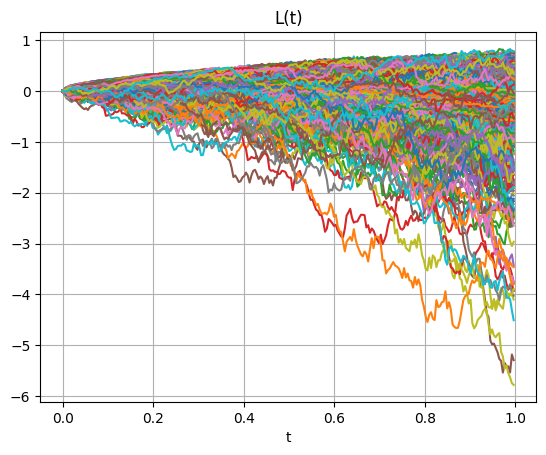

-0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# ==========================
# PARAMETROS GERAIS
# ==========================

np.random.seed(0)

M     = 1000      # nº de paths
K     = 150.0
S0    = 100.0     # moneyness S0/K = 1
T     = 1.0
t0    = 0.0
dt    = 0.05
mu    = 0.05
sigma = 0.2

sim = GBMSimulator(
        S0=S0,
        mu=mu,
        sigma=sigma,
        K=K,
        t0=t0,
        T=T,
        M=M
    )

S = sim.simulate_S()
H, dH_dS, d2H_dSS, dH_dt, d2H_dt_dS, d3H_dS3 = sim.simulate_H()
h0 = sim.init_control()
L = sim.forward_PL(h0)
LT = L[:,-1]
#risk = sim.risk_function(LT, risk_type='entw', gamma=1, k=2)
terminal_condition = sim.terminal_adjoint(LT, risk_type='ente', gamma=1, a=2)

t = sim.t0 + sim.dt * np.arange(sim.steps)

# helper simples
def plot_df(arr, title):
    df = pd.DataFrame(arr.T, index=t)   # tempo no index
    df.iloc[:, :].plot(legend=False)  # só 10 trajetórias
    plt.title(title)
    plt.xlabel("t")
    plt.grid(True)

# ----------------------------
# Plots (1 figura por objeto)
# ----------------------------
#plot_df(S, "S(t)")
#plot_df(H, "H(t,S)")
#plot_df(dH_dS, "Delta dH/dS")
#plot_df(d2H_dSS, "Gamma d²H/dS²")
#plot_df(d3H_dS3, "Third derivative d³H/dS³")
#plot_df(dH_dt, "Time derivative dH/dt")
#plot_df(d2H_dt_dS, "Mixed derivative d²H/(dt dS)")
plot_df(L, "L(t)")
plt.show()
print(terminal_condition)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# ==========================
# PARAMETROS GERAIS
# ==========================

np.random.seed(0)

M     = 1000      # nº de paths
K     = 100.0
S0    = 100.0     # moneyness S0/K = 1
T     = 1.0
t0    = 0.0
dt    = 0.05
mu    = 0.05
sigma = 0.2

# Heston
kappa   = 2.0
theta   = 0.04
sigma_v = 0.5
rho     = -0.5
v0      = 0.04

# Jump Diffusion (Merton)
lam = 1.0
mJ  = -0.05
sJ  = 0.1

# Medidas de risco e parâmetros
risk_specs = [
    ("ele",  {"a": 0.05}),
    ("elw",  {"k": 2.0}),
    ("entl", {"gamma": 0.5}),
    ("ente", {"gamma": 0.5, "a": 0.05}),
    ("entw", {"gamma": 0.5, "k": 2.0, "scale": 20.0}),
    ("es",   {"beta": 0.95}),
]

max_iter = 20
tol      = 1e-4
alpha    = 1e-3
verbose  = False

# ==========================
# FIGURE OUTPUT FOLDER
# ==========================

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ==========================
# FACTORIES DOS MODELOS
# ==========================

def make_gbm():
    return GBMSimulator(
        M=M,
        S0=S0,
        K=K,
        mu=mu,
        sigma=sigma,
        t0=t0,
        T=T,
    )

def make_heston():
    return HestonSimulator(
        M=M,
        S0=S0,
        K=K,
        mu=mu,
        sigma=sigma,
        t0=t0,
        T=T,
        kappa=kappa,
        theta=theta,
        sigma_v=sigma_v,
        rho=rho,
        v0=v0,
    )

def make_jump():
    return JumpDiffusionSimulator(
        M=M,
        S0=S0,
        K=K,
        mu=mu,
        sigma=sigma,
        t0=t0,
        T=T,
        lam=lam,
        mJ=mJ,
        sJ=sJ,
    )

models = {
    "GBM": make_gbm,
    "Heston": make_heston,
    "Jump": make_jump,
}

# ==========================
# CONTÊINERS PARA RESULTADOS
# ==========================

S_paths     = {}
H_paths     = {}
t_grids     = {}
Eh_curves   = {}           # Eh_curves[modelo][risk_type] = E[h](t)
LT_samples  = {}           # LT_samples[modelo][risk_type] = L_T paths
risk_rows   = []           # para tabela final

# ==========================
# LOOP PRINCIPAL
# ==========================

for model_name, factory in models.items():
    print(f"modelo: {model_name}")
    sim = factory()

    # 1) S e H (uma vez por modelo)
    S_path = sim.simulate_S()
    sim.simulate_H()

    M_paths, N_time = S_path.shape
    t_grid = np.linspace(sim.t0, sim.T, N_time)

    S_paths[model_name] = S_path
    H_paths[model_name] = sim.H
    t_grids[model_name] = t_grid
    Eh_curves[model_name] = {}
    LT_samples[model_name] = {}

    # 2) loop sobre medidas de risco
    for risk_type, risk_kwargs in risk_specs:
        print(f"  medida: {risk_type}")
        h_star, history = sim.optimize_hedge(
            risk_type=risk_type,
            risk_kwargs=risk_kwargs,
            max_iter=max_iter,
            tol=tol,
            alpha=alpha,
            verbose=verbose,
        )

        # E[h](t)
        Eh = h_star.mean(axis=0)   # (N_time-1,)
        Eh_curves[model_name][risk_type] = Eh

        # P&L
        L = sim.forward_PL(h_star, L0=0.0)
        LT = L[:, -1]
        LT_samples[model_name][risk_type] = LT

        # risco no instante final
        rho_LT = sim.risk_function(LT, risk_type, **risk_kwargs)
        risk_rows.append({
            "Modelo": model_name,
            "Medida": risk_type,
            "rho(L_T)": rho_LT,
        })

# ==========================
# GRÁFICOS S (3 gráficos, com legendas)
# ==========================

for model_name in ["GBM", "Heston", "Jump"]:
    S_path = S_paths[model_name]
    t_grid = t_grids[model_name]

    plt.figure()
    n_show = min(30, S_path.shape[0])

    if model_name == "GBM":
        label_S = "Sample simulated underlying path (GBM)"
    elif model_name == "Heston":
        label_S = "Sample simulated underlying path (Heston)"
    else:
        label_S = "Sample simulated underlying path (Jump diffusion)"

    # primeira curva com label para legenda
    plt.plot(t_grid, S_path[0, :], linewidth=0.7, label=label_S)
    for m in range(1, n_show):
        plt.plot(t_grid, S_path[m, :], linewidth=0.7)

    plt.xlabel("Time")
    plt.ylabel("Underlying price")
    plt.title(f"Simulated underlying price paths ({model_name})")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"simulated_underlying_{model_name}.png"), dpi=300)
    plt.close()

# ==========================
# GRÁFICOS H (3 gráficos, com legendas)
# ==========================

for model_name in ["GBM", "Heston", "Jump"]:
    H = H_paths[model_name]
    t_grid = t_grids[model_name]

    plt.figure()
    n_show = min(30, H.shape[0])

    if model_name == "GBM":
        label_H = "Sample simulated contingent claim path (GBM)"
    elif model_name == "Heston":
        label_H = "Sample simulated contingent claim path (Heston)"
    else:
        label_H = "Sample simulated contingent claim path (Jump diffusion)"

    plt.plot(t_grid, H[0, :], linewidth=0.7, label=label_H)
    for m in range(1, n_show):
        plt.plot(t_grid, H[m, :], linewidth=0.7)

    plt.xlabel("Time")
    plt.ylabel("Contingent claim value")
    plt.title(f"Simulated contingent claim price paths ({model_name})")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"simulated_contingent_{model_name}.png"), dpi=300)
    plt.close()

# ==========================
# GRÁFICOS E[h] (3 gráficos, 6 curvas cada)
# ==========================

# legend labels a bit clearer but still short
risk_legend_labels = {
    "ele":  "ELE",
    "elw":  "ELW",
    "entl": "ENTL",
    "ente": "ENTE",
    "entw": "ENTW",
    "es":   "ES",
}

for model_name in ["GBM", "Heston", "Jump"]:
    t_grid = t_grids[model_name]
    plt.figure()
    for risk_type, _ in risk_specs:
        Eh = Eh_curves[model_name][risk_type]
        label = risk_legend_labels.get(risk_type, risk_type)
        plt.plot(t_grid[:-1], Eh, linewidth=0.9, label=label)
    plt.xlabel("Time")
    plt.ylabel("Average hedge ratio")
    plt.title(f"Average hedge ratio over time ({model_name})")
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"average_hedge_{model_name}.png"), dpi=300)
    plt.close()

# ==========================
# HISTOGRAMAS L_T (18 subplots numa figura, com títulos)
# ==========================

n_models = len(models)
n_risks  = len(risk_specs)

# calcular intervalo global de L_T para ajeitar os eixos
all_LT = []
for model_name in ["GBM", "Heston", "Jump"]:
    for risk_type, _ in risk_specs:
        all_LT.append(LT_samples[model_name][risk_type])
all_LT = np.concatenate(all_LT)
xmin, xmax = np.min(all_LT), np.max(all_LT)
dx = xmax - xmin if xmax > xmin else 1.0
xmin_plot = xmin - 0.05 * dx
xmax_plot = xmax + 0.05 * dx

fig, axes = plt.subplots(
    n_models, n_risks,
    figsize=(3 * n_risks, 2.5 * n_models),
    squeeze=False
)

for i, model_name in enumerate(["GBM", "Heston", "Jump"]):
    for j, (risk_type, _) in enumerate(risk_specs):
        ax = axes[i, j]
        LT = LT_samples[model_name][risk_type]
        ax.hist(LT, bins=30, density=True, edgecolor="black", linewidth=0.4)
        ax.set_xlim(xmin_plot, xmax_plot)
        ax.set_title(f"{model_name} - {risk_type}", fontsize=7)
        ax.tick_params(axis="x", labelsize=6)
        ax.tick_params(axis="y", labelsize=6)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "histograms_LT_all_models.png"), dpi=300)
plt.close()

# ==========================
# TABELA FINAL rho(L_T)
# ==========================

risk_table = pd.DataFrame(risk_rows)
print(risk_table.pivot(index="Modelo", columns="Medida", values="rho(L_T)"))


In [ ]:
# ==========================
# CONTAINERS FOR RESULTS
# ==========================

S_paths     = {}
H_paths     = {}
t_grids     = {}
Eh_curves   = {}           # Eh_curves[model][risk_type] = E[h](t)
LT_samples  = {}           # LT_samples[model][risk_type_opt] = L_T paths (under that optimized measure)
risk_rows   = []           # for the big final table


# ==========================
# MAIN LOOP
# ==========================

for model_name, factory in models.items():
    print(f"model: {model_name}")
    sim = factory()

    # 1) S and H (once per model)
    S_path = sim.simulate_S()
    sim.simulate_H()

    M_paths, N_time = S_path.shape
    t_grid = np.linspace(sim.t0, sim.T, N_time)

    S_paths[model_name] = S_path
    H_paths[model_name] = sim.H
    t_grids[model_name] = t_grid
    Eh_curves[model_name] = {}
    LT_samples[model_name] = {}

    # 2) loop over risk measures used in the optimization
    for risk_type_opt, risk_kwargs_opt in risk_specs:
        print(f"  optimized measure: {risk_type_opt}")
        h_star, history = sim.optimize_hedge(
            risk_type=risk_type_opt,
            risk_kwargs=risk_kwargs_opt,
            max_iter=max_iter,
            tol=tol,
            alpha=alpha,
            verbose=verbose,
        )

        # E[h](t) under this optimized strategy
        Eh = h_star.mean(axis=0)   # (N_time-1,)
        Eh_curves[model_name][risk_type_opt] = Eh

        # P&L under this optimized strategy
        L = sim.forward_PL(h_star, L0=0.0)
        LT = L[:, -1]
        LT_samples[model_name][risk_type_opt] = LT

        # 3) evaluate ALL risk measures on this same LT
        for risk_type_eval, risk_kwargs_eval_base in risk_specs:
            # use a copy of kwargs to avoid accidental mutation
            risk_kwargs_eval = risk_kwargs_eval_base.copy()
            rho_LT_eval = sim.risk_function(LT, risk_type_eval, **risk_kwargs_eval)
            risk_rows.append({
                "Model": model_name,
                "Optimized": risk_type_opt,
                "Evaluated": risk_type_eval,
                "rho(L_T)": rho_LT_eval,
            })


# ==========================
# BIG TABLE rho(L_T) FOR ALL COMBINATIONS
# ==========================

risk_table = pd.DataFrame(risk_rows)

# pivot so that rows = (Model, Optimized), columns = Evaluated measure
pivot_table = risk_table.pivot_table(
    index=["Model", "Optimized"],
    columns="Evaluated",
    values="rho(L_T)"
)

print(pivot_table)


In [ ]:
pivot_table